In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [4]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'mvpa2')

In [5]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [6]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)
        # clap to remove outlier
        clip_range = 5 
        features = np.clip(features, -clip_range, clip_range)
        # convert all to non-negative
        features = (features + clip_range) / (2 * clip_range)

    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [7]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [8]:
PROCESSED_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 
    'results', 'stats', 'gaze', 'inverted_enc')

### A modified version of data loading, which compute extra stats for df

In [9]:
ISI_phase = np.arange(start=2500//50, stop=3000//50).astype(int) # 10 time points
delay_phase = np.arange(start=4750//50, stop=9250//50).astype(int)
delay_phases = np.split(delay_phase, 9) # 9 x 10 time points

In [10]:
from utils.inverted_encoding import deg_signed_diff

N_SD_BINS = 6 # cut sd-diff into N_SD_BINS many bins

def group_and_divie_from_median(A, B, N_groups):
    # Define the bins and labels
    bins = np.linspace(0, 90, num=N_groups+1)
    bin_ids = np.digitize(A, bins).astype(float) - 1 # nan -> N-group+1
    bin_ids[(bin_ids<0) | (bin_ids>=N_groups)]= np.nan
    bin_ids = bin_ids / N_groups # so it is comparable across different N_bins

    df = pd.DataFrame({'A': A, 'B': B, 'group': bin_ids})
    within_group_ids = np.full_like(B, np.nan, dtype='float')
    for group_id in df['group'].dropna().unique():
        group_mask = df['group'] == group_id
        B_values = df.loc[group_mask, 'B']
        B_median = B_values.median(skipna=True)

        if not np.isnan(B_median):
            # just set everything to nan
            within_group_ids[group_mask & (B_values < B_median)] = -1
            within_group_ids[group_mask & (B_values > B_median)] = 1
            within_group_ids[group_mask & (B_values == B_median)] = 0

    return bin_ids, within_group_ids

def load_subject_time_feature_with_sd_stats(subj, time_steps, normalize=True):
    features, df = load_subject_time_feature(subj, time_steps, normalize)
    # pad the df
    for stim_id in [1, 2]:
        resp_errs = deg_signed_diff(df[f'resp_{stim_id}']-df[f'stim_{stim_id}']).values
        sd_diffs = deg_signed_diff(df['prev_last_response']-df[f'stim_{stim_id}']).values

        # flip it
        neg_sd_diff_mask = sd_diffs < 0
        resp_errs[neg_sd_diff_mask] = -resp_errs[neg_sd_diff_mask]
        sd_diffs[neg_sd_diff_mask] = -sd_diffs[neg_sd_diff_mask]

        temp_bin_ids = np.full_like(sd_diffs, np.nan, dtype='float')
        temp_within_group_ids = np.full_like(sd_diffs, np.nan, dtype='float')

        for mode in ['draw', 'click']:
            mode_mask = df['mode'] == mode
            # get group ids and within-group ids
            bin_ids, within_group_ids = group_and_divie_from_median(
                sd_diffs[mode_mask], resp_errs[mode_mask], N_SD_BINS)
            temp_bin_ids[mode_mask] = bin_ids
            temp_within_group_ids[mode_mask] = within_group_ids
        
        df[f'sd_diff_group_{stim_id}'] = temp_bin_ids
        df[f'sd_diff_within_group_{stim_id}'] = temp_within_group_ids

    return features, df



In [11]:
from utils.inverted_encoding import raw_reformat_all_loaded

def reformat_all_loaded(phase, stim_names, cond_lmb):
    return raw_reformat_all_loaded(
        load_func=load_subject_time_feature_with_sd_stats,
        subjs=all_subjs,
        phase=phase, stim_names=stim_names, 
        cond_lmb=cond_lmb
    )

In [12]:
example_feature, example_df = load_subject_time_feature_with_sd_stats(
    all_subjs[0], ISI_phase, normalize=True)

In [13]:
exp_df = pd.DataFrame({
    'A': [np.nan]
})
np.isnan(exp_df['A'].median(skipna=True))

True

## Load Functions for inverted encoding

In [14]:
from utils.inverted_encoding import ForwardModel

d2_H, d2_W = 15, 15

DEFAULT_FEATURE_CONVERSION = {
    # '0d': { 'old': np.array([0, 1]),},
    '1d': {
        'old': np.arange(2, 32),
        'zoom_ratio': 1.0,
    },
    '2d': {
        'old': np.arange(32, 32+d2_H*d2_W),
        'H': d2_H,
        'W': d2_W,
        'zoom_ratio': 0.4,
    }    
}

In [15]:
DEFAULT_N_CHANNELS = 18

In [16]:
sharpness_range = [0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 30, 40]

In [17]:
valid_1st_lmb = lambda df: ((df['stim_1_to_report']) | (df['trial_code'] == 1)).to_numpy()
ISI_xs, ISI_ys, _, _ = reformat_all_loaded(ISI_phase, ['stim_1'], valid_1st_lmb)

In [18]:
ISI_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=DEFAULT_N_CHANNELS)
ISI_best_sharpness, ISI_best_loss = ISI_forward_model.find_best_y_transform(
    ISI_xs, ISI_ys, item_weights=np.ones_like(ISI_ys), 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)


In [19]:
valid_both_lmb = lambda df: (
    (df['stim_1_to_report'] & df['stim_2_to_report']) | 
    (df['trial_code'] == 1)).to_numpy()

delay_xs, delay_ys, delay_dfs, _ = reformat_all_loaded(
    delay_phase, ['stim_1', 'stim_2'], valid_both_lmb)

In [20]:
from utils.inverted_encoding import convert_df_to_delay_design_matrix
item_weights_lmb = lambda df: convert_df_to_delay_design_matrix(df)

In [21]:
delay_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=DEFAULT_N_CHANNELS)
item_weights = item_weights_lmb(delay_dfs)
delay_best_sharpness, delay_best_loss = delay_forward_model.find_best_y_transform(
    delay_xs, delay_ys, item_weights=item_weights, 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)

In [22]:
DEFAULT_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION,
        'n_channels': DEFAULT_N_CHANNELS,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

In [23]:
from utils.inverted_encoding import raw_across_subj_cross_phase_iterator

def across_subj_cross_phase_iterator(*args, **kwargs):
    return raw_across_subj_cross_phase_iterator(
        reformat_all_loaded,
        *args, **kwargs
    )

from utils.inverted_encoding import raw_cv_train_test_invert_encoding

def cv_train_test_invert_encoding(*args, **kwargs):
    return raw_cv_train_test_invert_encoding(
        across_subj_cross_phase_iterator,
        *args, **kwargs
    )

## Check the bias the whole delay

### Train & Test (the whole delay)

In [24]:
n_subjects = len(all_subjs)
full_delay_phase_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    # valid_both_lmb, valid_both_lmb, 
    None, None,
    item_weights_lmb, n_subjects)

Processing: 100%|██████████| 36/36 [00:14<00:00,  2.40it/s]


In [25]:
delay_model = ForwardModel(**DEFAULT_FORWARD_MODEL_PARAMS['init'])
delay_sharpness = DEFAULT_FORWARD_MODEL_PARAMS['forward']['sharpness']

In [26]:
from utils.inverted_encoding import raw_channel_weights_to_pseudo_distrib

DELAY_CHANNEL_PRED_MEAN = np.mean(full_delay_phase_results['preds'])
DELAY_CHANNEL_PRED_STD = np.std(full_delay_phase_results['preds'])

def channel_weights_to_pseudo_distrib(channel_weights, model, sharpness):
    return raw_channel_weights_to_pseudo_distrib(
       channel_weights, model, sharpness,
       delay_channel_pred_mean=DELAY_CHANNEL_PRED_MEAN,
       delay_channel_pred_std=DELAY_CHANNEL_PRED_STD
    )
    

In [27]:
from utils.inverted_encoding import shift_align_distrib
from utils.inverted_encoding import raw_display_shifted_distrib

def display_shifted_distrib(*args, **kwargs):
    if 'ylim_min' not in kwargs:
        kwargs['ylim_min'] = 0.0040
    if 'ylim_max' not in kwargs:
        kwargs['ylim_max'] = 0.0075
    return raw_display_shifted_distrib(*args, **kwargs)

In [28]:
from utils.inverted_encoding import raw_display_stats_and_distrib

def display_stats_and_distrib(
        ax, # set to None to disable visualization
        results, stats_type, 
        common_lmb=None, condition_lmbs={}, item_weights_lmb=None, 
        sharpness=delay_best_sharpness, # sharpness to convert to distrib
        return_subj_stats=False # if to return each subject's stats
    ):
    return raw_display_stats_and_distrib(
        ax, results, stats_type, 
        common_lmb=common_lmb, condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb,
        sharpness=sharpness, return_subj_stats=return_subj_stats,
        surrogate_model=delay_model,
        prediction_conversion_func=channel_weights_to_pseudo_distrib,
        display_shifted_distrib_func=display_shifted_distrib
    )


### Split by SD diffs

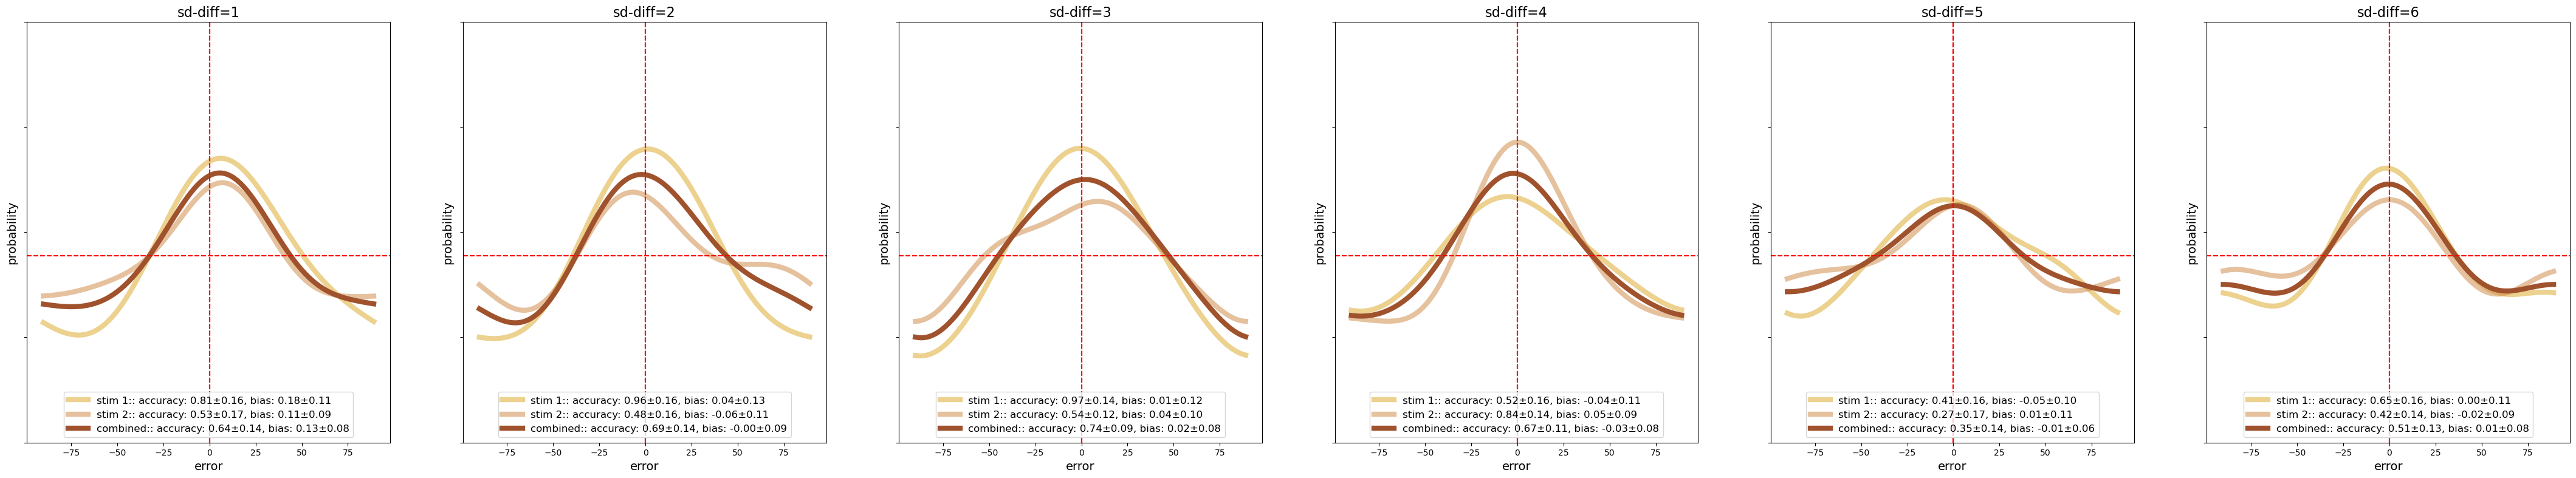

In [29]:
fig, axs = plt.subplots(1, N_SD_BINS, figsize=(9*N_SD_BINS, 9))
for sd_bin_id in np.arange(N_SD_BINS):
    sd_bin_val = sd_bin_id / N_SD_BINS 
    sd1_lmb = lambda d: (
        (d['sd_diff_group_1'] == sd_bin_val)
    ).values
    sd2_lmb = lambda d: (
        (d['sd_diff_group_2'] == sd_bin_val)
    ).values
    sd_valid_lmb = lambda d: (
        (d['sd_diff_group_1'] == sd_bin_val) | 
        (d['sd_diff_group_2'] == sd_bin_val)
    ).values
    plot_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': sd1_lmb,
            # 'to_plot': False,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': sd2_lmb,
            # 'to_plot': False,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        }
    }
    ax = axs[sd_bin_id]
    display_stats_and_distrib(ax,
        full_delay_phase_results,
        stats_type='accuracy', 
        common_lmb=sd_valid_lmb, condition_lmbs=plot_settings,
        item_weights_lmb=item_weights_lmb)
    ax.set_title(f'sd-diff={sd_bin_id+1}', fontsize=16)

plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_acc_as_sd_diff_func.png')
plt.savefig(plot_path, bbox_inches='tight')

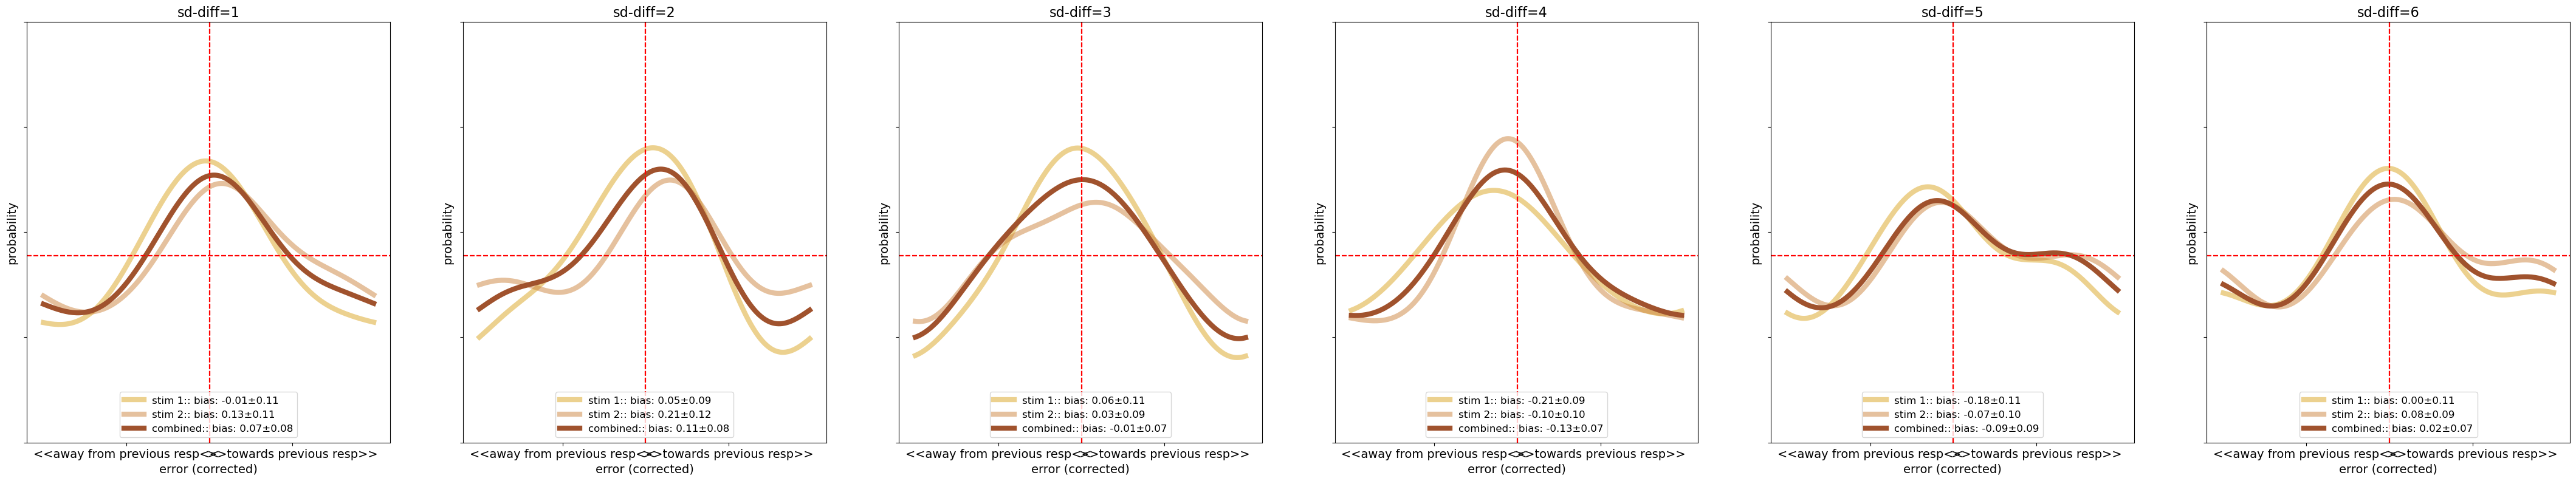

In [30]:
fig, axs = plt.subplots(1, N_SD_BINS, figsize=(9*N_SD_BINS, 9))
for sd_bin_id in np.arange(N_SD_BINS):
    sd_bin_val = sd_bin_id / N_SD_BINS 
    sd1_lmb = lambda d: (
        (d['sd_diff_group_1'] == sd_bin_val)
    ).values
    sd2_lmb = lambda d: (
        (d['sd_diff_group_2'] == sd_bin_val)
    ).values
    sd_valid_lmb = lambda d: (
        (d['sd_diff_group_1'] == sd_bin_val) | 
        (d['sd_diff_group_2'] == sd_bin_val) |
        (~(d['prev_last_response'].isna()))
    ).values
    plot_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': sd1_lmb,
            # 'to_plot': False,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': sd2_lmb,
            # 'to_plot': False,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        }
    }
    ax = axs[sd_bin_id]
    display_stats_and_distrib(ax,
        full_delay_phase_results,
        stats_type='sd', 
        common_lmb=sd_valid_lmb, condition_lmbs=plot_settings,
        item_weights_lmb=item_weights_lmb)
    ax.set_title(f'sd-diff={sd_bin_id+1}', fontsize=16)

plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_sd_as_sd_diff_func.png')
plt.savefig(plot_path, bbox_inches='tight')

### Split by most positive v.s. negative behavior serial bias

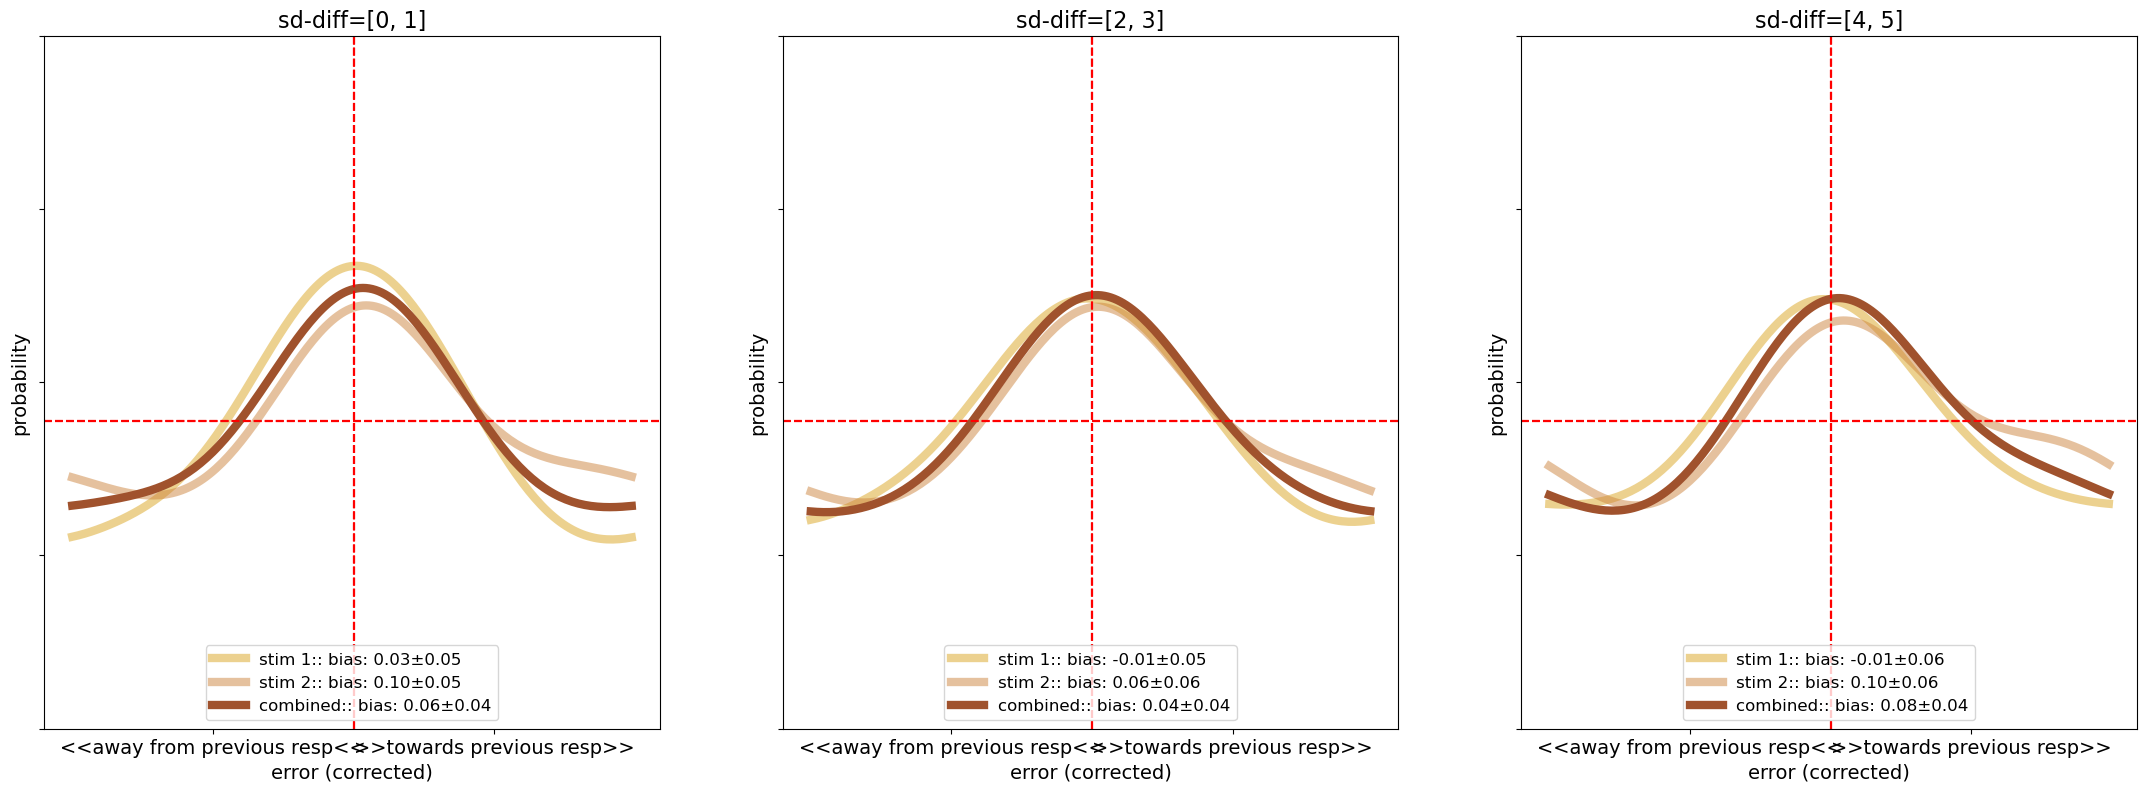

In [31]:
sd_diff_ranges = [
    [0, N_SD_BINS//3-1],
    [N_SD_BINS//3, 2*N_SD_BINS//3-1],
    [2*N_SD_BINS//3, N_SD_BINS-1],
]
fig, axs = plt.subplots(1, len(sd_diff_ranges), figsize=(9*len(sd_diff_ranges), 9))
for ax_id in range(len(sd_diff_ranges)):
    sd_bin_vals = np.array(sd_diff_ranges[ax_id]) / N_SD_BINS 
    sd1_lmb = lambda d: (
        (d['sd_diff_group_1'].isin(sd_bin_vals)) |
        (d['sd_diff_within_group_1'] == 1.0)
    ).values
    sd2_lmb = lambda d: (
        (d['sd_diff_group_2'].isin(sd_bin_vals)) |
        (d['sd_diff_within_group_2'] == 1.0)
    ).values
    sd_valid_lmb = lambda d: (
        (sd1_lmb(d) | sd2_lmb(d)) &
        (~(d['prev_last_response'].isna()))
    ).values
    plot_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': sd1_lmb,
            # 'to_plot': False,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': sd2_lmb,
            # 'to_plot': False,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        }
    }
    ax = axs[ax_id]
    display_stats_and_distrib(ax,
        full_delay_phase_results,
        stats_type='sd', 
        common_lmb=sd_valid_lmb, condition_lmbs=plot_settings,
        item_weights_lmb=item_weights_lmb)
    ax.set_title(f'sd-diff={sd_diff_ranges[ax_id]}', fontsize=16)

plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_sd_as_sd_diff_func_sd_combined_large_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

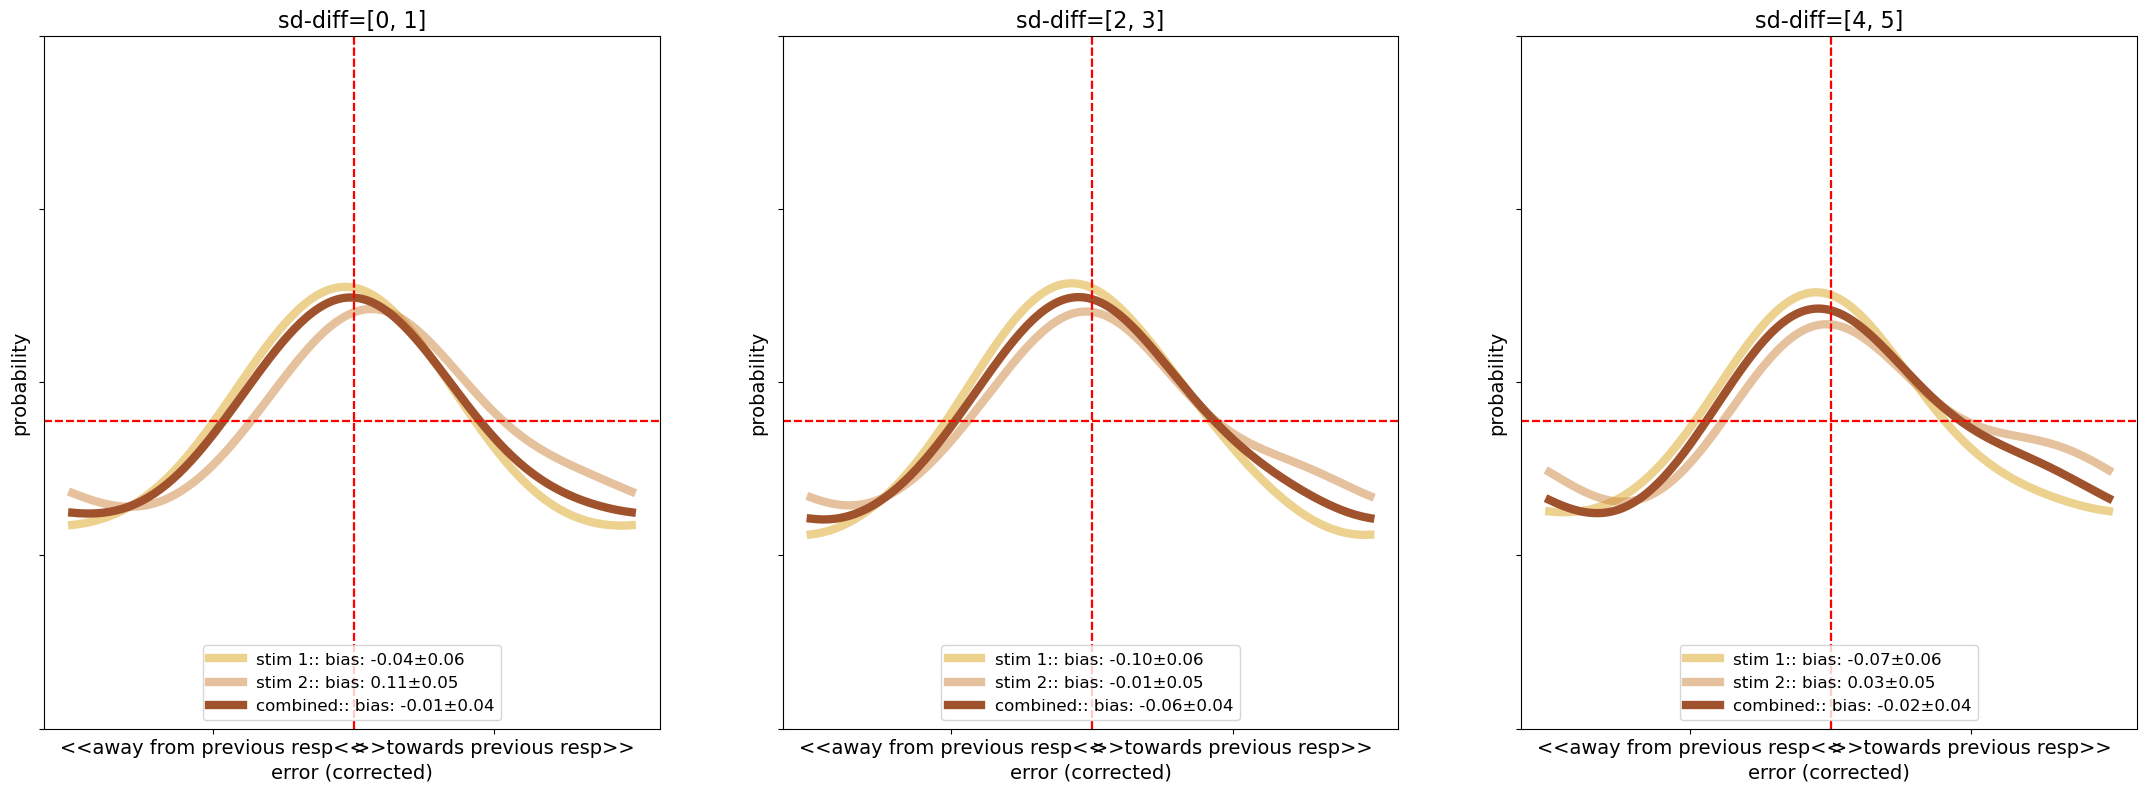

In [32]:
sd_diff_ranges = [
    [0, N_SD_BINS//3-1],
    [N_SD_BINS//3, 2*N_SD_BINS//3-1],
    [2*N_SD_BINS//3, N_SD_BINS-1],
]
fig, axs = plt.subplots(1, len(sd_diff_ranges), figsize=(9*len(sd_diff_ranges), 9))
for ax_id in range(len(sd_diff_ranges)):
    sd_bin_vals = np.array(sd_diff_ranges[ax_id]) / N_SD_BINS 
    sd1_lmb = lambda d: (
        (d['sd_diff_group_1'].isin(sd_bin_vals)) |
        (d['sd_diff_within_group_1'] == -1.0)
    ).values
    sd2_lmb = lambda d: (
        (d['sd_diff_group_2'].isin(sd_bin_vals)) |
        (d['sd_diff_within_group_2'] == -1.0)
    ).values
    sd_valid_lmb = lambda d: (
        (sd1_lmb(d) | sd2_lmb(d)) &
        (~(d['prev_last_response'].isna()))
    ).values
    plot_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': sd1_lmb,
            # 'to_plot': False,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': sd2_lmb,
            # 'to_plot': False,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        }
    }
    ax = axs[ax_id]
    display_stats_and_distrib(ax,
        full_delay_phase_results,
        stats_type='sd', 
        common_lmb=sd_valid_lmb, condition_lmbs=plot_settings,
        item_weights_lmb=item_weights_lmb)
    ax.set_title(f'sd-diff={sd_diff_ranges[ax_id]}', fontsize=16)

plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_sd_as_sd_diff_func_sd_combined_small_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

## The time phase of accuracy and biases

In [34]:
from utils.inverted_encoding import generate_windows

DELAY_WINDOWS = generate_windows(delay_phase, 30, 7)
N_DELAY_WINDOW = len(DELAY_WINDOWS)
print(f'{N_DELAY_WINDOW} windows, each of {len(DELAY_WINDOWS[0])} time points')

9 windows, each of 30 time points


In [35]:
from utils.inverted_encoding import raw_within_across_phase_train_test

def within_across_phase_train_test(phases, train_test_lmb):
    return raw_within_across_phase_train_test(
        phases, train_test_lmb, 
        subjs=all_subjs,
        train_test_iterator=across_subj_cross_phase_iterator,
        model_params=DEFAULT_FORWARD_MODEL_PARAMS,
        item_weights_lmb=item_weights_lmb
    )

In [36]:
from utils.inverted_encoding import (
    raw_plot_single_stats_over_phase,
    raw_plot_stats_over_phase
)

def plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=None, plot_ymax=None, label=None,
        x_offset=0, color=None, alpha=1):

    return raw_plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=plot_ymin, plot_ymax=plot_ymax, label=label,
        stats_computation_func=display_stats_and_distrib,
        item_weights_lmb=item_weights_lmb,
        x_offset=x_offset, color=color, alpha=alpha)

def plot_stats_over_phase(
        pred_results, stats_type, plot_settings, 
        common_lmb, plot_ymin=None, plot_ymax=None):
    return raw_plot_stats_over_phase(
        pred_results, stats_type, plot_settings,
        common_lmb, plot_ymin=plot_ymin, plot_ymax=plot_ymax,
        stats_computation_func=display_stats_and_distrib,
        item_weights_lmb=item_weights_lmb,
    )

### Drawing

In [37]:
draw_both_lmb = lambda df: ((df['mode'] == 'draw').to_numpy() & valid_both_lmb(df))

In [38]:
draw_mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, draw_both_lmb)

100%|██████████| 9/9 [02:32<00:00, 16.91s/it]


In [55]:
sd_diff_dicts = {
    'small': [0, N_SD_BINS//2-1],
    # 'medium': [N_SD_BINS//3, 2*N_SD_BINS//3-1],
    'large': [N_SD_BINS//2, N_SD_BINS-1],
}
x_shift_sd_diff = {
    'small': -0.1,
    # 'medium': 0.0,
    'large': 0.1,
}
sd_diff_color_dicts = {
    'small': 'orangered',
    # 'medium': 'goldenrod',
    'large': 'saddlebrown',
}


In [56]:
sd_bias_dicts = {
    'pos': 1.0,
    'neg': -1.0,
}
x_shift_sd_bias = {
    'pos': -0.05,
    'neg': 0.05,
}
sd_bias_alpha_dicts = {
    'pos': 1.0,
    'neg': 0.4,
}

#### check only different sd diff

In [57]:
def plot_stats_as_sd_diff_func(results, stat_type, stat_name, ylabel, plot_name, plot_ymin, plot_ymax, lmb, phase_step=0):
    fig, ax = plt.subplots(1, figsize=(6, 4))
    for sd_diff_name in sd_diff_dicts:
        sd_bin_vals = np.array(sd_diff_dicts[sd_diff_name]) / N_SD_BINS 
        sd1_lmb = lambda d: (
            (d['sd_diff_group_1'].isin(sd_bin_vals))
        ).values
        sd2_lmb = lambda d: (
            (d['sd_diff_group_2'].isin(sd_bin_vals)) 
        ).values
        sd_valid_lmb = lambda d: (
            (sd1_lmb(d) | sd2_lmb(d)) &
            (~(d['prev_last_response'].isna()))
        ).values
        plot_settings = {
            'stim 1': {
                'target': 'stim 1',
                'lmb': sd1_lmb,
                # 'to_plot': False,
            },
            'stim 2': {
                'target': 'stim 2',
                'lmb': sd2_lmb,
                # 'to_plot': False,
            },
            'combined': {
                'target': 'combined',
                'lmb': sd_valid_lmb,
            }
        }

        plot_single_stats_over_phase(
            ax, results, 
            stat_type, stat_name, phase_step,
            plot_settings, lmb, 
            plot_ymin=plot_ymin, plot_ymax=plot_ymax, 
            label=f'{sd_diff_name} sd-diff',
            x_offset=x_shift_sd_diff[sd_diff_name],
            color=sd_diff_color_dicts[sd_diff_name],
            alpha=1.0)

    ax.set_ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right')

    plot_path = os.path.join(PLOTS_FOLDER, f'{plot_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

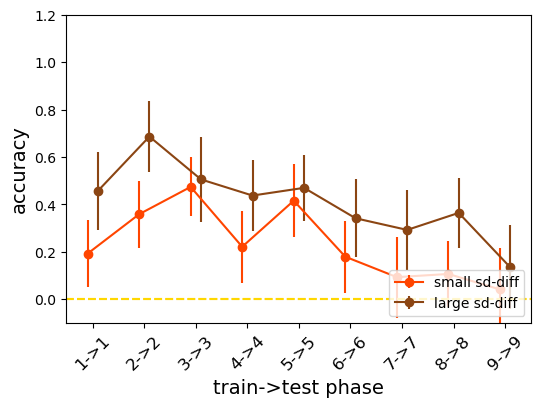

In [58]:
plot_stats_as_sd_diff_func(
    results=draw_mem2_cross_phase_results[0], 
    stat_type='accuracy', stat_name='accuracy', 
    ylabel='accuracy', plot_name='delay_phase_draw_acc_sd_diff_func', 
    plot_ymin=-0.1, plot_ymax=1.2, lmb=draw_both_lmb)

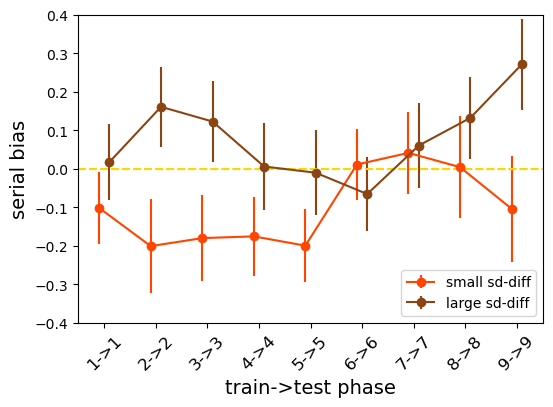

In [59]:
plot_stats_as_sd_diff_func(
    results=draw_mem2_cross_phase_results[0], 
    stat_type='sd', stat_name='bias', 
    ylabel='serial bias', plot_name='delay_phase_draw_sd_sd_diff_func', 
    plot_ymin=-0.4, plot_ymax=0.4, lmb=draw_both_lmb)

#### check only more positive v.s. more negative behavior bias

In [62]:
def plot_stats_as_sd_diff_behav_bias_func(results, plot_name, plot_ymin=-0.4, plot_ymax=0.4, lmb=None, phase_step=0):
    sd_diff_names = ['small', 'large']
    fig, axs = plt.subplots(1, len(sd_diff_names), figsize=(6*len(sd_diff_names), 4))

    for i, sd_diff_name in enumerate(sd_diff_names):
        ax = axs[i]
        for sd_bias_name in sd_bias_dicts:
            sd_bin_vals = np.array(sd_diff_dicts[sd_diff_name]) / N_SD_BINS 
            sd1_lmb = lambda d: (
                (d['sd_diff_group_1'].isin(sd_bin_vals)) |
                (d['sd_diff_within_group_1'] == sd_bias_dicts[sd_bias_name])
            ).values
            sd2_lmb = lambda d: (
                (d['sd_diff_group_2'].isin(sd_bin_vals)) |
                (d['sd_diff_within_group_2'] == sd_bias_dicts[sd_bias_name])
            ).values
            sd_valid_lmb = lambda d: (
                (sd1_lmb(d) | sd2_lmb(d)) &
                (~(d['prev_last_response'].isna()))
            ).values
            plot_settings = {
                'stim 1': {
                    'target': 'stim 1',
                    'lmb': sd1_lmb,
                    # 'to_plot': False,
                },
                'stim 2': {
                    'target': 'stim 2',
                    'lmb': sd2_lmb,
                    # 'to_plot': False,
                },
                'combined': {
                    'target': 'combined',
                    'lmb': None,
                }
            }

            plot_single_stats_over_phase(
                ax, results, 
                'sd', 'bias', phase_step,
                plot_settings, lmb, 
                plot_ymin=plot_ymin, plot_ymax=plot_ymax, 
                label=f'more {sd_bias_name} behav',
                x_offset=x_shift_sd_bias[sd_bias_name],
                color=sd_diff_color_dicts[sd_diff_name],
                alpha=sd_bias_alpha_dicts[sd_bias_name])
        ax.legend(
            bbox_to_anchor=(1.0, 0.0), loc='lower right')
        ax.set_title(f'sd-diff={sd_diff_name}', fontsize=16)
        ax.set_ylabel('serial bias')

    plot_path = os.path.join(PLOTS_FOLDER, f'{plot_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

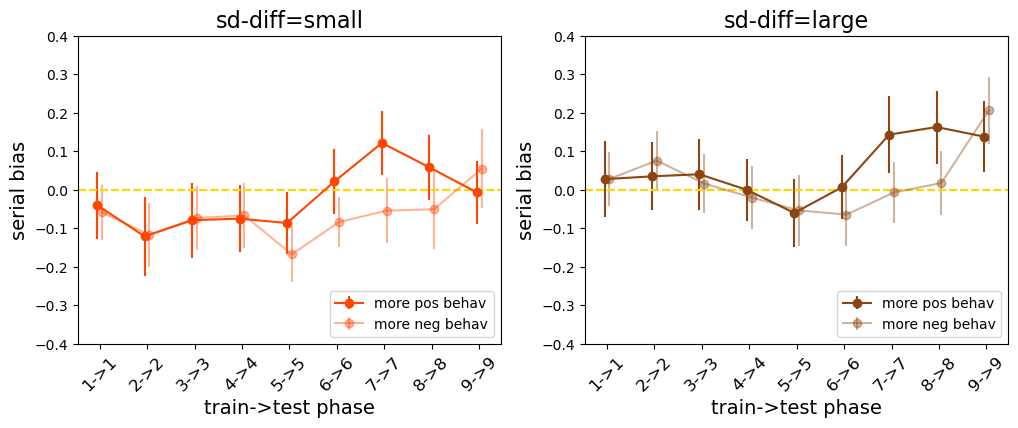

In [63]:
plot_stats_as_sd_diff_behav_bias_func(
    results=draw_mem2_cross_phase_results[0], 
    plot_name='delay_phase_draw_sd_sd_diff_sd_bias_func', 
    plot_ymin=-0.4, plot_ymax=0.4, lmb=draw_both_lmb)

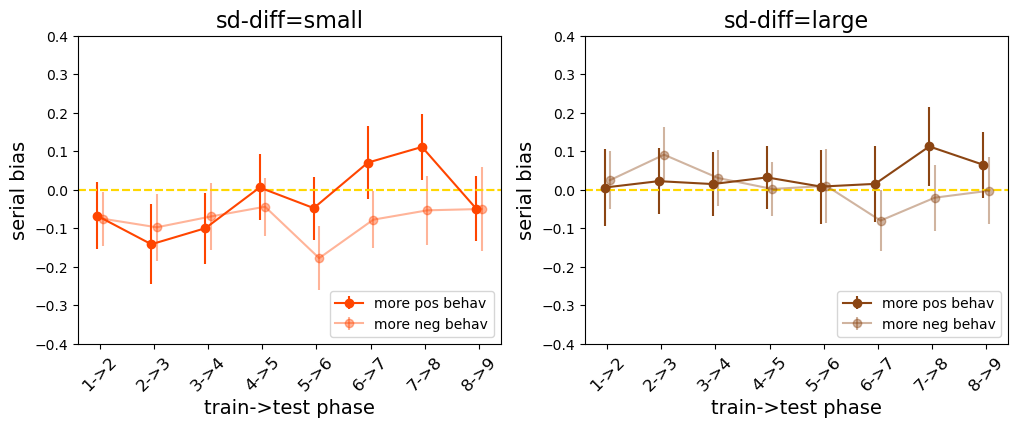

In [64]:
plot_stats_as_sd_diff_behav_bias_func(
    results=draw_mem2_cross_phase_results[1], 
    plot_name='delay_cross_phase_draw_sd_sd_diff_sd_bias_func', 
    plot_ymin=-0.4, plot_ymax=0.4, lmb=draw_both_lmb,
    phase_step=1)


### Clicking


In [47]:
click_both_lmb = lambda df: (
    (df['mode'] == 'click').to_numpy() & valid_both_lmb(df))

In [48]:
click_mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, click_both_lmb)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [02:47<00:00, 18.61s/it]


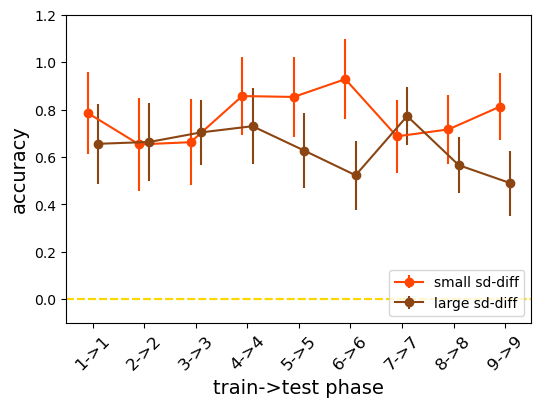

In [65]:
plot_stats_as_sd_diff_func(
    results=click_mem2_cross_phase_results[0], 
    stat_type='accuracy', stat_name='accuracy', 
    ylabel='accuracy', plot_name='delay_phase_click_acc_sd_diff_func', 
    plot_ymin=-0.1, plot_ymax=1.2, lmb=click_both_lmb)

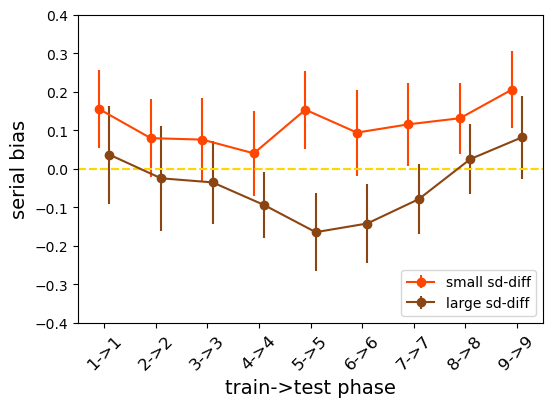

In [66]:
plot_stats_as_sd_diff_func(
    results=click_mem2_cross_phase_results[0], 
    stat_type='sd', stat_name='bias', 
    ylabel='serial bias', plot_name='delay_phase_click_sd_sd_diff_func', 
    plot_ymin=-0.4, plot_ymax=0.4, lmb=click_both_lmb)

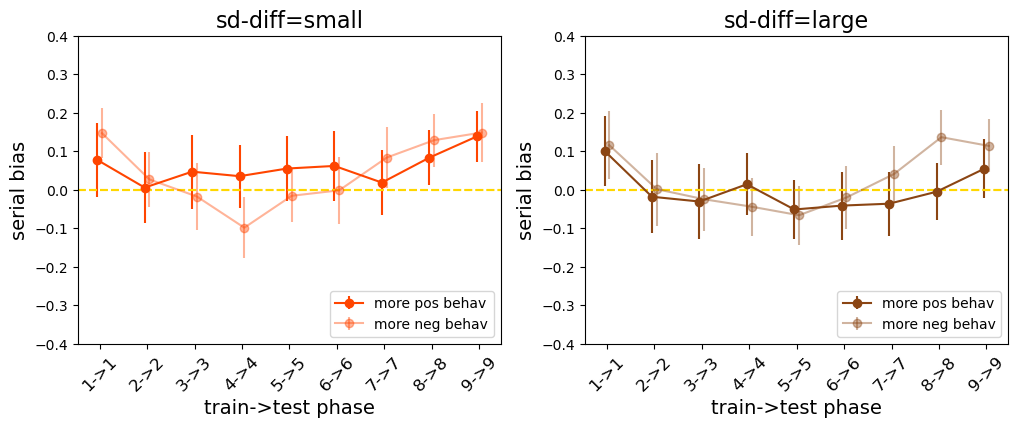

In [67]:
plot_stats_as_sd_diff_behav_bias_func(
    results=click_mem2_cross_phase_results[0], 
    plot_name='delay_phase_click_sd_sd_diff_sd_bias_func', 
    plot_ymin=-0.4, plot_ymax=0.4, lmb=click_both_lmb)

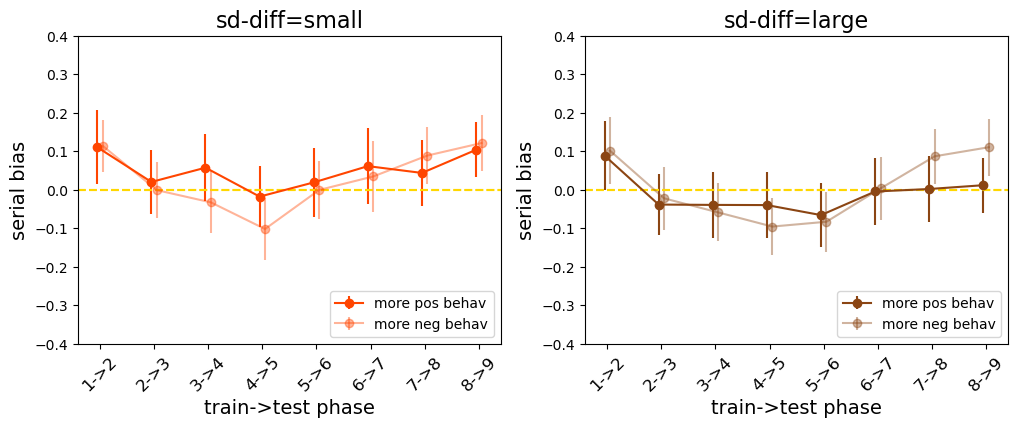

In [68]:
plot_stats_as_sd_diff_behav_bias_func(
    results=click_mem2_cross_phase_results[1], 
    plot_name='delay_cross_phase_click_sd_sd_diff_sd_bias_func', 
    plot_ymin=-0.4, plot_ymax=0.4, lmb=click_both_lmb,
    phase_step=1)

### Combined Both Modes

In [53]:
mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, valid_both_lmb)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [02:48<00:00, 18.73s/it]


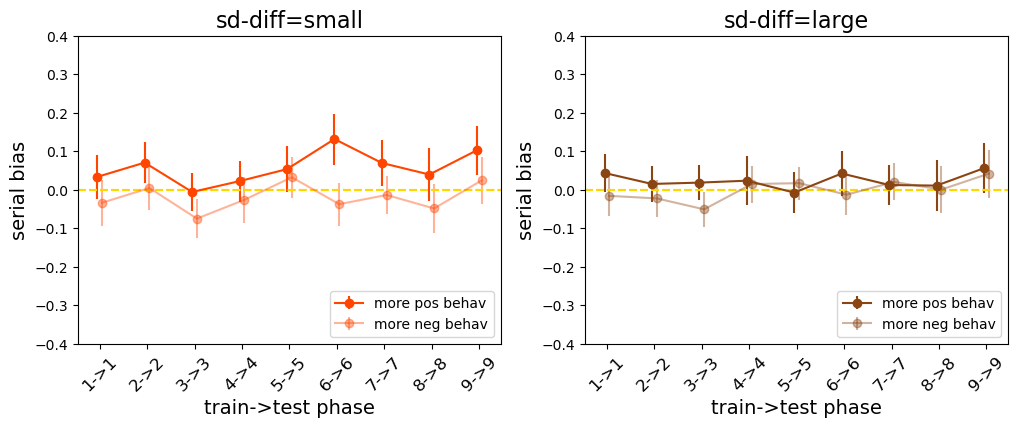

In [69]:
plot_stats_as_sd_diff_behav_bias_func(
    results=mem2_cross_phase_results[0], 
    plot_name='delay_phase_sd_sd_diff_sd_bias_func', 
    plot_ymin=-0.4, plot_ymax=0.4, lmb=valid_both_lmb)

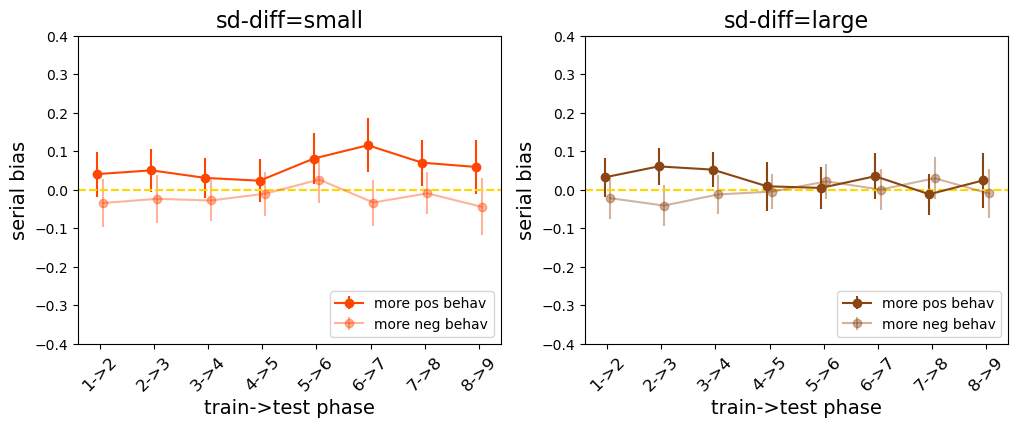

In [70]:
plot_stats_as_sd_diff_behav_bias_func(
    results=mem2_cross_phase_results[1], 
    plot_name='delay_cross_phase_sd_sd_diff_sd_bias_func', 
    plot_ymin=-0.4, plot_ymax=0.4, lmb=valid_both_lmb,
    phase_step=1)

### plot all combined

In [71]:
has_valid_prev_lmb = lambda df: ~(df['prev_last_response'].isna().values)

In [72]:
mode_phase_results = {
    'draw': draw_mem2_cross_phase_results,
    'click': click_mem2_cross_phase_results,
}
mode_lmbs = {
    'draw': draw_both_lmb,
    'click': click_both_lmb,
}
mode_color_dicts = {
    'draw': 'blue',
    'click': 'brown',
}

In [73]:
def plot_all_combined_phase_mode_compare(stat_type, stat_name, plot_ymin, plot_ymax):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    plot_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': None,
            # 'to_plot': False,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': None,
            # 'to_plot': False,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        }
    }

    mode_phase_results = {
        'draw': draw_mem2_cross_phase_results,
        'click': click_mem2_cross_phase_results,
    }
    mode_lmbs = {
        'draw': draw_both_lmb,
        'click': click_both_lmb,
    }
    mode_color_dicts = {
        'draw': 'blue',
        'click': 'brown',
    }

    for phase_step in [0, 1]:
        ax = axs[phase_step]
        for mode in ['draw', 'click']:
            selected_mode_lmb = mode_lmbs[mode]
            selected_lmb = lambda d: (selected_mode_lmb(d) & has_valid_prev_lmb(d))
            x_offset = -0.05 if mode == 'draw' else 0.05
            plot_single_stats_over_phase(
                ax, mode_phase_results[mode][phase_step], 
                stat_type, stat_name, phase_step,
                plot_settings, selected_lmb, 
                plot_ymin=plot_ymin, plot_ymax=plot_ymax, 
                label=f'{mode}',
                x_offset=x_offset,
                color=mode_color_dicts[mode],
                alpha=1.0)

        ax.set_ylabel('Serial Bias')
        ax.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right')

    plot_path = os.path.join(PLOTS_FOLDER, f'delay_phase_{stat_type}_{stat_name}_mode_compare.png')
    plt.savefig(plot_path, bbox_inches='tight')

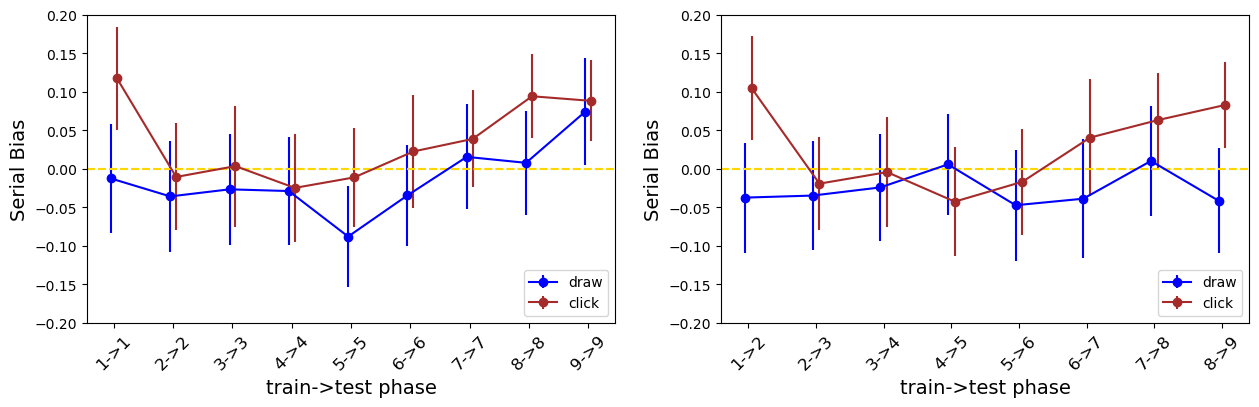

In [74]:
plot_all_combined_phase_mode_compare('sd', 'bias', plot_ymin=-0.2, plot_ymax=0.2)

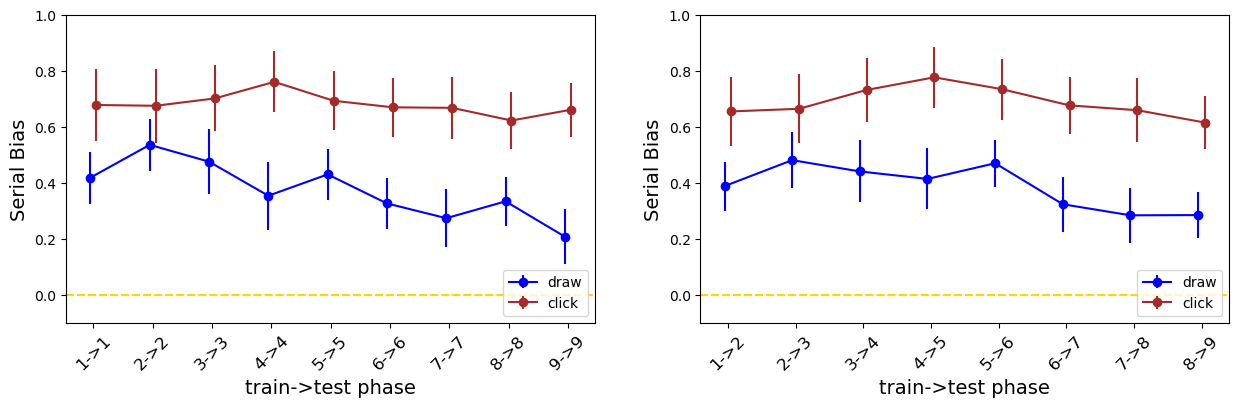

In [75]:
plot_all_combined_phase_mode_compare('accuracy', 'accuracy', plot_ymin=-0.1, plot_ymax=1.0)